# Resolution-dependence tests at higher Rayleigh number
Now that I am able to stabilise the model at high Rayleigh numbers with hyperdiffusion, I repeat the previous resolution-dependence tests.

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import modules.regridding as regridding

## Spin-up time

In [3]:
data = xr.open_mfdataset(
    '../data/restest_highRa/restest_highRa_1024_128/restest_highRa_1024_128_s*.nc',
    chunks={'t': -1, 'x': 128, 'z': 128})
data = data.drop_duplicates('t')

In [5]:
w_mid = data.w.interp(z=0.5).chunk({'t': -1, 'x': -1})
w_bin_edges = np.linspace(0, 0.9, 20)
w_bin_centers = (w_bin_edges[:-1] + w_bin_edges[1:])/2

t_bin_edges = w_mid.t.data[::200]
t_bin_centers = (t_bin_edges[:-1] + t_bin_edges[1:])/2
w_mid_grouped = np.abs(w_mid).groupby_bins('t', t_bin_edges)
w_mid_hist = w_mid_grouped.map(
    lambda a: a.groupby_bins(a, w_bin_edges).count().fillna(0))
w_mid_99 = w_mid_grouped.quantile(0.99, dim=['x', 't'])

v_rms = np.sqrt((data.u**2 + data.w**2).mean(['x', 'z']))
v_rms = v_rms.groupby_bins('t', t_bin_edges).mean()

In [6]:
theta_mid = data.theta.interp(z=0.5).chunk({'t': -1, 'x': -1})
theta_bin_edges = np.linspace(0, 0.2, 20)
theta_bin_centers = (theta_bin_edges[:-1] + theta_bin_edges[1:])/2

t_bin_edges = theta_mid.t.data[::200]
t_bin_centers = (t_bin_edges[:-1] + t_bin_edges[1:])/2
theta_mid_grouped = np.abs(theta_mid).groupby_bins('t', t_bin_edges)
theta_mid_hist = theta_mid_grouped.map(
    lambda a: a.groupby_bins(a, theta_bin_edges).count().fillna(0))
theta_mid_99 = theta_mid_grouped.quantile(0.99, dim=['x', 't'])

theta_rms = np.sqrt((data.theta**2).mean(['x', 'z']))
theta_rms = theta_rms.groupby_bins('t', t_bin_edges).mean()

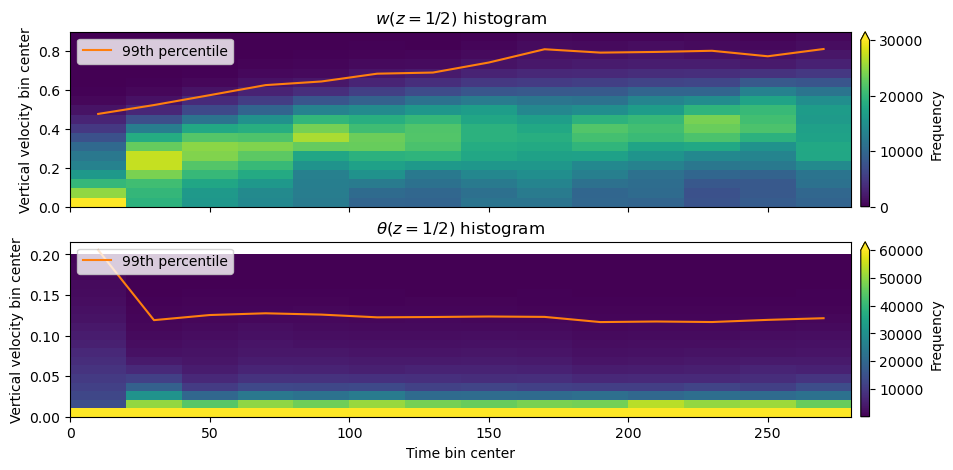

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

mesh = axes[0].pcolormesh(t_bin_centers, w_bin_centers, w_mid_hist.T, vmax=3e4)
fig.colorbar(mesh, ax=axes[0], label='Frequency', extend='max', pad=0.01)
axes[0].plot(
    t_bin_centers, w_mid_99, color='tab:orange', label='99th percentile')
axes[0].set(
    ylabel='Vertical velocity bin center', title='$w(z=1/2)$ histogram')
axes[0].legend(loc='upper left')

mesh = axes[1].pcolormesh(
    t_bin_centers, theta_bin_centers, theta_mid_hist.T, vmax=6e4)
fig.colorbar(mesh, ax=axes[1], label='Frequency', extend='max', pad=0.01)
axes[1].plot(
    t_bin_centers, theta_mid_99, color='tab:orange', label='99th percentile')
axes[1].set(
    xlabel='Time bin center', ylabel='Vertical velocity bin center',
    title=r'$\theta(z=1/2)$ histogram',
)
axes[1].legend(loc='upper left')

[Text(0.5, 0, 'Time bin center'),
 Text(0, 0.5, 'Percentage change'),
 Text(0.5, 1.0, 'Temperature statistics')]

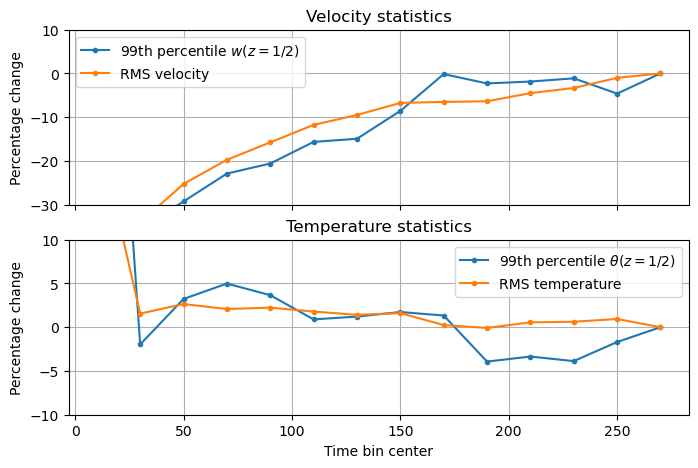

In [31]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True)

axes[0].plot(
    t_bin_centers, (w_mid_99/w_mid_99[-1] - 1)*1e2, '.-',
    label='99th percentile $w(z=1/2)$')
axes[0].plot(
    t_bin_centers, (v_rms/v_rms[-1] - 1)*1e2, '.-', label='RMS velocity')
axes[0].legend()
axes[0].set_ylim(-30, 10)
axes[0].grid()
axes[0].set(ylabel='Percentage change', title='Velocity statistics')

axes[1].plot(
    t_bin_centers, (theta_mid_99/theta_mid_99[-1] - 1)*1e2, '.-',
    label=r'99th percentile $\theta(z=1/2)$')
axes[1].plot(
    t_bin_centers, (theta_rms/theta_rms[-1] - 1)*1e2, '.-',
    label='RMS temperature',
)
axes[1].legend()
axes[1].set_ylim(-10, 10)
axes[1].grid()
axes[1].set(
    xlabel='Time bin center', ylabel='Percentage change',
    title='Temperature statistics')

## Simulation length

In [7]:
t_spinup = 200
end_times = data.t[data.t > t_spinup][::50]

def w_percentile_99(end_time):
    array = w_mid[(data.t >= t_spinup) & (data.t <= end_time)]
    return array.quantile(0.99)

def theta_percentile_99(end_time):
    array = theta_mid[(data.t >= t_spinup) & (data.t <= end_time)]
    return array.quantile(0.99)

w_percentiles = xr.apply_ufunc(w_percentile_99, end_times, vectorize=True)
theta_percentiles = xr.apply_ufunc(
    theta_percentile_99, end_times, vectorize=True)

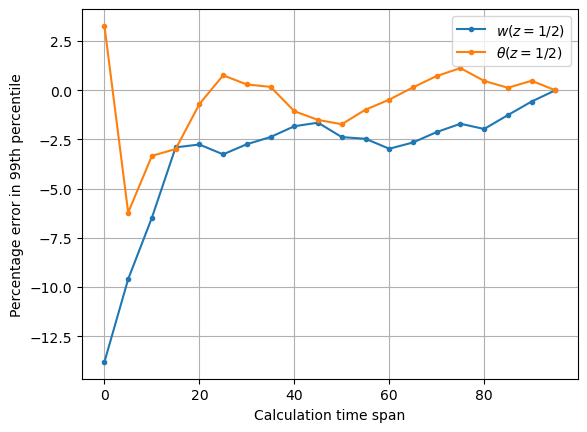

In [10]:
fig, ax = plt.subplots()
ax.plot(
    end_times - t_spinup, (w_percentiles/w_percentiles[-1] - 1)*1e2,
    '.-', label='$w(z=1/2)$')
ax.plot(
    end_times - t_spinup, (theta_percentiles/theta_percentiles[-1] - 1)*1e2,
    '.-', label=r'$\theta(z=1/2)$')
ax.set(
    xlabel='Calculation time span',
    ylabel='Percentage error in 99th percentile')
ax.legend()
ax.grid()

## Model runs
We are now ready to run the model at each resolution. It would be unrealistic to keep the time step constant, so I will instead scale it in proportion to the spatial resolution by fixing the Courant number. That is, if the subscripts 1 and 2 denote two different runs,
$$
    \Delta t_1 \left( \frac{u_1}{\Delta x_1} + \frac{w_1}{\Delta z_1} \right)
    = \Delta t_2 \left( \frac{u_2}{\Delta x_2} + \frac{w_2}{\Delta z_2} \right).
$$
If we assume that the runs have similar velocities, and that the vertical and horizontal velocity scales are similar, this reduces to
$$
\begin{align*}
    \Delta t_2 &\approx \frac{1/\Delta x_1 + 1/\Delta z_1}{1/\Delta x_2 + 1/\Delta z_2} \Delta t_1\\
    &\approx \frac{N_{x1}/\alpha + N_{z1}}{N_{x2}/\alpha + N_{z2}} \Delta t_1
\end{align*}
$$
where $\alpha = 8$ is the aspect ratio. The table below shows the $(N_x, N_z)$ pairs that will be tested, and the corresponding time steps (to 3 significant figures).

In [8]:
nx0 = 1024
nz0 = 128
dt0 = 2e-3
alpha = 8

nx = np.array([256, 384, 512, 768, 1024])
nz = np.array([32, 48, 64, 96, 128])
nx, nz = np.meshgrid(nx, nz)
dt = (nx0/alpha + nz0)/(nx/alpha + nz)*dt0
dt = np.round(dt*1e3, 2)

both_pow2 = (np.log2(nx) % 1 == 0) & (np.log2(nz) % 1 == 0)
neither_pow2 = (np.log2(nx) % 1 != 0) & (np.log2(nz) % 1 != 0)
mask = both_pow2 | neither_pow2
dt[~mask] = np.nan

nx_set = nx.flatten()[mask.flatten()][:-1]
nz_set = nz.flatten()[mask.flatten()][:-1]
dt_set = dt.flatten()[mask.flatten()][:-1]
print('(N_x, N_z, dt):')
print(np.array(list(zip(nx_set, nz_set, dt_set))))

(N_x, N_z, dt):
[[ 256.     32.      8.  ]
 [ 512.     32.      5.33]
 [1024.     32.      3.2 ]
 [ 384.     48.      5.33]
 [ 768.     48.      3.56]
 [ 256.     64.      5.33]
 [ 512.     64.      4.  ]
 [1024.     64.      2.67]
 [ 384.     96.      3.56]
 [ 768.     96.      2.67]
 [ 256.    128.      3.2 ]
 [ 512.    128.      2.67]]


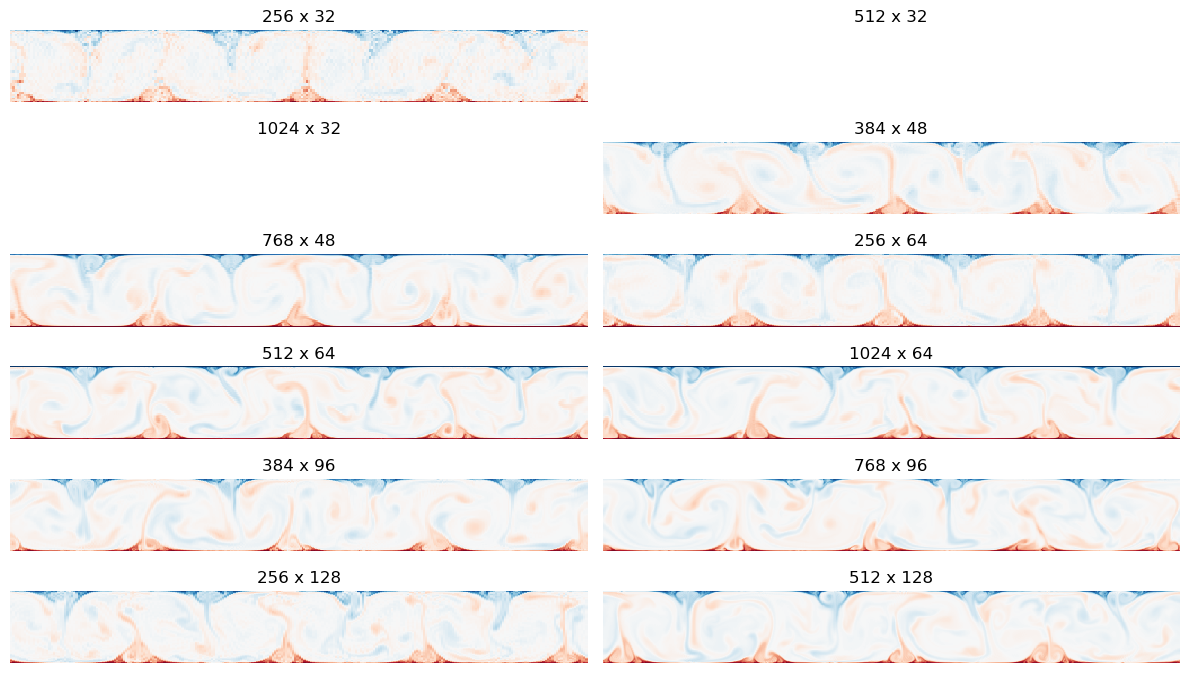

In [12]:
def plot_theta(nx, nz, ax):
    data = xr.open_mfdataset(
        f'../data/restest_highRa/restest_highRa_{nx:d}_{nz:d}'
        f'/restest_highRa_{nx:d}_{nz:d}_s*.nc'
    )

    ax.pcolormesh(data.x, data.z, data.theta.interp(t=200).T, cmap='RdBu_r')
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(f'{nx:d} x {nz:d}')

fig, axes = plt.subplots(6, 2, figsize=(12, 7))
for i in range(len(nx_set)):
    plot_theta(nx_set[i], nz_set[i], axes.flat[i])
fig.tight_layout()

## 99th percentile velocity

In [17]:
coarsest = xr.open_mfdataset(
    '../data/restest_highRa/restest_highRa_256_32/restest_highRa_256_32_s*.nc')
coarsest = coarsest.isel(t=((coarsest.t >= 200) & (coarsest.t <= 300)))

def w_99(nx, nz):
    try:
        data = xr.open_mfdataset(
            f'../data/restest_highRa/restest_highRa_{nx:d}_{nz:d}'
            f'/restest_highRa_{nx:d}_{nz:d}_s*.nc'
        )
    except OSError:
        return np.nan

    # interpolate w onto the mid-plane
    w_mid = data.w[(data.t >= 200) & (data.t <= 300)].interp(z=0.5)
    w_mid = w_mid.chunk({'t': -1, 'x': -1})

    # coarse-grain in x and t
    regridder = regridding.Regridder2D(w_mid, coarsest, ('x', 't'))
    w_mid_coarse = regridder(w_mid)

    return np.abs(w_mid_coarse).quantile(0.99)

nx = [256, 384, 512, 768, 1024]
nz = [48, 64, 96, 128]
nx = xr.DataArray(nx, coords=[nx], dims=['nx'])
nz = xr.DataArray(nz, coords=[nz], dims=['nz'])

percentiles = xr.apply_ufunc(w_99, nx, nz, vectorize=True)

[Text(0.5, 0, '$N_x$'), Text(0, 0.5, '$N_z$')]

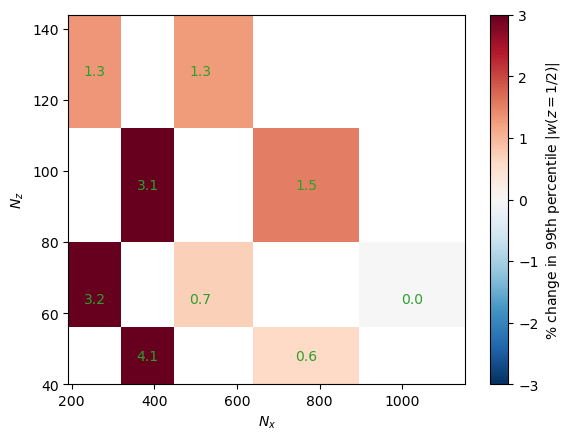

In [18]:
fig, ax = plt.subplots()
deviation = (percentiles.T/percentiles.sel(nx=1024, nz=64) - 1)*1e2
mesh = ax.pcolormesh(
    deviation.nx, deviation.nz, deviation, vmin=-3, vmax=3, cmap='RdBu_r')
for _nx in nx:
    for _nz in nz:
        value = deviation.sel(nx=_nx, nz=_nz)
        if ~np.isnan(value):
            ax.text(
                _nx, _nz, f'{value:.1f}',
                horizontalalignment='center',
                verticalalignment='center',
                color='tab:green'
            )
fig.colorbar(
    mesh, ax=ax, label='% change in 99th percentile $|w(z=1/2)|$')
ax.set(xlabel='$N_x$', ylabel='$N_z$')